In [3]:
import numpy as np
from sklearn.datasets import fetch_openml

In [96]:
openml_frame = fetch_openml(data_id=42477, as_frame=True)

In [97]:
print(openml_frame['DESCR'])

**Author**: Yeh, I. C., & Lien, C. H
**Source**: [original](https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients#) - 2016-01-26  
**Please cite**: Yeh, I. C., & Lien, C. H. (2009). The comparisons of data mining techniques for the predictive accuracy of probability of default of credit card clients. Expert Systems with Applications, 36(2), 2473-2480.

   

Data Set Information:

This research aimed at the case of customersâ€™ default payments in Taiwan and compares the predictive accuracy of probability of default among six data mining methods. From the perspective of risk management, the result of predictive accuracy of the estimated probability of default will be more valuable than the binary result of classification - credible or not credible clients. Because the real probability of default is unknown, this study presented the novel Sorting Smoothing Method to estimate the real probability of default. With the real probability of default as the response variable (

In [98]:
data = openml_frame['data']

In [99]:
data.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x18,x19,x20,x21,x22,x23
0,20000.0,2.0,2.0,1.0,24.0,2.0,2.0,-1.0,-1.0,-2.0,-2.0,3913.0,3102.0,689.0,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0
1,120000.0,2.0,2.0,2.0,26.0,-1.0,2.0,0.0,0.0,0.0,2.0,2682.0,1725.0,2682.0,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0
2,90000.0,2.0,2.0,2.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,29239.0,14027.0,13559.0,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0
3,50000.0,2.0,2.0,1.0,37.0,0.0,0.0,0.0,0.0,0.0,0.0,46990.0,48233.0,49291.0,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0
4,50000.0,1.0,2.0,1.0,57.0,-1.0,0.0,-1.0,0.0,0.0,0.0,8617.0,5670.0,35835.0,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0


In [100]:
data.columns

Index(['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10', 'x11',
       'x12', 'x13', 'x14', 'x15', 'x16', 'x17', 'x18', 'x19', 'x20', 'x21',
       'x22', 'x23'],
      dtype='object')

In [101]:
openml_frame.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'DESCR', 'details', 'categories', 'url'])

In [129]:
openml_frame['feature_names']

['x1',
 'x2',
 'x3',
 'x4',
 'x5',
 'x6',
 'x7',
 'x8',
 'x9',
 'x10',
 'x11',
 'x12',
 'x13',
 'x14',
 'x15',
 'x16',
 'x17',
 'x18',
 'x19',
 'x20',
 'x21',
 'x22',
 'x23']

In [102]:
data.dtypes

x1     float64
x2     float64
x3     float64
x4     float64
x5     float64
x6     float64
x7     float64
x8     float64
x9     float64
x10    float64
x11    float64
x12    float64
x13    float64
x14    float64
x15    float64
x16    float64
x17    float64
x18    float64
x19    float64
x20    float64
x21    float64
x22    float64
x23    float64
dtype: object

In [103]:
cat_cols = list(data.select_dtypes(include='category').columns)
num_cols = list(data.select_dtypes(exclude='category').columns)

In [104]:
cat_cols

[]

In [105]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
X1 = cat_encoder.fit_transform(data[cat_cols]).todense()
scaler = StandardScaler()
X2 = scaler.fit_transform(
    data[num_cols]
)
X = np.concatenate([X1, X2], axis=1)
feature_names = list(cat_encoder.get_feature_names()) + num_cols

In [106]:
X.shape

(30000, 23)

In [112]:
from sklearn.model_selection import train_test_split

target_dict = {val: num for num, val in enumerate(list(openml_frame['target'].unique()))}
y = openml_frame['target'].apply(lambda x: target_dict[x]).astype('float').values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42
)

In [113]:
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
#import tensorflow.compat.v2 as tf
tfd = tfp.distributions
%matplotlib inline

In [114]:
negloglik = lambda y, rv_y: -rv_y.log_prob(y)

In [115]:
# Specify the prior over `keras.layers.Dense` `kernel` and `bias`.
def prior_trainable(kernel_size, bias_size=0, dtype=None):
    n = kernel_size + bias_size
    return tf.keras.Sequential([
    tfp.layers.VariableLayer(n, dtype=dtype),
    tfp.layers.DistributionLambda(lambda t: tfd.Independent(
        tfd.Normal(loc=t, scale=1),
        reinterpreted_batch_ndims=1)),
    ])

In [116]:
# Specify the surrogate posterior over `keras.layers.Dense` `kernel` and `bias`.
def posterior_mean_field(kernel_size, bias_size=0, dtype=None):
    n = kernel_size + bias_size
    c = np.log(np.expm1(1.))
    return tf.keras.Sequential([
    tfp.layers.VariableLayer(2 * n, dtype=dtype),
    tfp.layers.DistributionLambda(lambda t: tfd.Independent(
        tfd.Normal(
            loc=t[..., :n],
            scale=1e-5 + tf.nn.softplus(c + t[..., n:])
        ),
    reinterpreted_batch_ndims=1)),
    ])

In [130]:
model = tf.keras.Sequential([
    tfp.layers.DenseVariational(2, posterior_mean_field, prior_trainable, kl_weight=1/X.shape[0]),
    tfp.layers.DistributionLambda(
        lambda t: tfd.Normal(
            loc=t[..., :1],
            scale=1e-3 + tf.math.softplus(0.01 * t[...,1:])
        )
    ),
])

In [169]:
model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.01),
    loss=negloglik
)
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=1000,
    verbose=False,
    callbacks=[callback]
)

In [170]:
preds = model(X_test)

In [171]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, preds.mean().numpy())

0.7041085670903314

In [172]:
import scipy
scipy.stats.spearmanr(np.abs(y_test - preds.mean().numpy().squeeze()), preds.variance().numpy().squeeze())

SpearmanrResult(correlation=0.6026589006825015, pvalue=0.0)

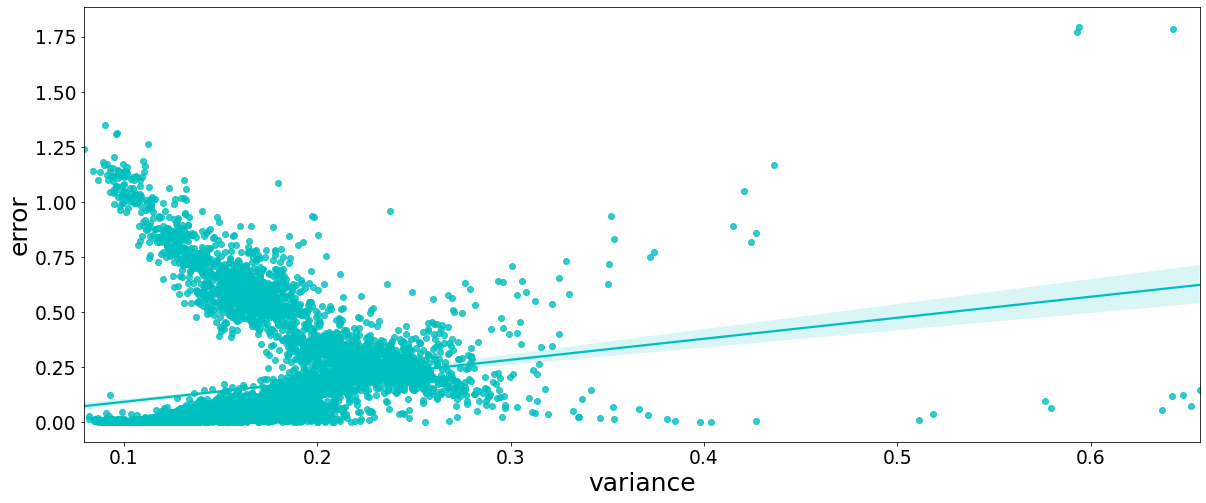

In [173]:
import seaborn as sns
size=25
params = {
    'legend.fontsize': 'large',
    'figure.figsize': (20, 8),
    'axes.labelsize': size,
    'axes.titlesize': size,
    'xtick.labelsize': size * 0.75,
    'ytick.labelsize': size * 0.75,
    'axes.titlepad': 25
}
plt.rcParams.update(params)

error = y_test - preds.mean().numpy().squeeze()
ax = sns.regplot(
    x=preds.variance().numpy().squeeze(),
    y=error*error,
    color='c'
)
plt.ylabel('error')
plt.xlabel('variance');

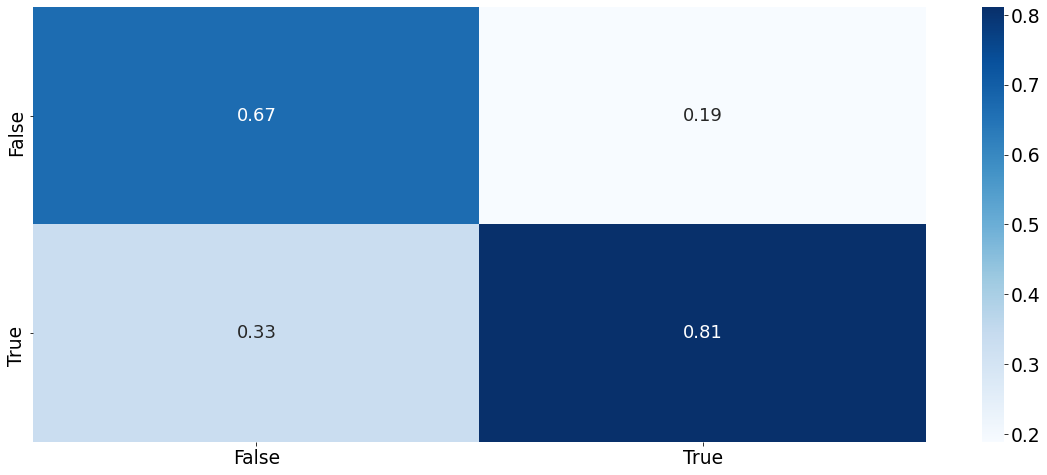

In [174]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import pandas as pd

cm = confusion_matrix(y_test, preds.mean().numpy() >= 0.5)
cm = pd.DataFrame(data=cm / cm.sum(axis=0), columns=['False', 'True'], index=['False', 'True'])
sns.heatmap(
    cm,
    fmt='.2f',
    cmap='Blues',
    annot=True,
    annot_kws={'fontsize': 18}
)